# 收入影响因素分析

本文尽力解释收入影响因素评分模型的设计过程，分为以下几个部分：
1. 数据初探
2. 备选模型及验证
3. 结论

## 1. 数据初探

读入数据，先看看各变量的关系


<img src="./static/single_plot.png" width = "70%" height = "50%" alt="single_plot" align=center />

可以看出 $FEE$和各变量之间有比较明显的线性关系，考虑使用使用以下模型求解：
1. Lasso（线性）
2. Ridge（线性）
3. Gradient Boosting Regression（非线性）

## 2. 模型验证及训练

### 模型训练及比较

先导入各种包和读入数据

In [67]:
import numpy as np
import pandas as pd


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model, model_selection

raw_data = pd.read_csv(r'./data/FEE.csv')
heads = raw_data.columns
# (0,1) transformation
scaler = MinMaxScaler(feature_range=(0, 1))
raw_data = pd.DataFrame(scaler.fit_transform(raw_data))
raw_data.columns = heads
# get X,y from raw data
X = raw_data.drop(['OP_TIME', 'FEE'], axis=1)
# get polynomial features
# poly = PolynomialFeatures(degree=2) 
# degree取了2，3，4，score 不如什么都不做好，不使用PolynomialFeatures了
# poly_X = pd.DataFrame(poly.fit_transform(X))
poly_X = X
y = raw_data['FEE']
# outer 10-fold
kf = KFold(n_splits=10)

使用$ nested\ 10-fold$交叉验证来寻找相对合适的超参数，找到超参数后，用$sklearn.metrics$来评估三个备选模型，评价标准是MSE,$sklearn.cross\_val\_score$给MSE加了一个负号，它用_score表示越大越好的值，_loss表示越小越好的值，所以在这里看到一个负的MSE也就可以解释得通了。（然而给人的感觉还是很奇怪！！）

下面分别来看看三个模型的表现吧。

In [68]:
mean_performance = [] #记录不同模型的评分

#### Lasso Regression

In [69]:
scores = [] #记录寻找超参时不同超参的评分
lasso_models = [] #寻找超参数时记录良好超参对应的model
for train_index, test_index in kf.split(poly_X):
    print("start training...")
    X_train, X_test = poly_X.iloc[train_index], poly_X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lassocv = linear_model.LassoCV(cv=10, max_iter=1500)
    lassocv.fit(X_train, y_train)
    print ("alpha is %s" % (lassocv.alpha_))
    lasso = linear_model.Lasso(alpha=lassocv.alpha_).fit(X_train, y_train)
    lasso_models.append(lasso)
    score = lasso.score(X_test, y_test)
    scores.append(score)
scores_ndarray = np.asarray(scores)
best_model = lasso_models[scores_ndarray.argmax()]
cv_result = model_selection.cross_val_score(best_model, poly_X, y, cv=kf, scoring='neg_mean_squared_error')
print ('the mean neg_mse_score for LassoRegression is %s' % (np.mean(np.asarray(cv_result))))
mean_performance.append(np.mean(np.asarray(cv_result)))
lasso = best_model # 记下这个模型，后面会用到

start training...
alpha is 6.30097409285e-05
start training...
alpha is 6.96642847494e-05
start training...
alpha is 7.75473987246e-05
start training...
alpha is 8.18540787075e-05
start training...
alpha is 8.04580882601e-05
start training...
alpha is 8.06931621568e-05
start training...
alpha is 8.01326064739e-05
start training...
alpha is 7.61452461207e-05
start training...
alpha is 6.80458904209e-05
start training...
alpha is 6.05176273968e-05
the mean neg_mse_score for LassoRegression is -0.000190264530221


#### Ridge Regression

In [70]:
ridge_scores = [] #记录寻找超参时不同超参的评分
ridge_models = [] #寻找超参数时记录良好超参对应的model
for train_index, test_index in kf.split(poly_X):
    print("start training...")
    X_train, X_test = poly_X.iloc[train_index], poly_X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lassocv = linear_model.RidgeCV(cv=10, alphas=[0.01, 0.03, 0.1, 0.3, 1, 3])
    lassocv.fit(X_train, y_train)
    print ("alpha is %s" % (lassocv.alpha_))
    lasso = linear_model.Ridge(alpha=lassocv.alpha_).fit(X_train, y_train)
    ridge_models.append(lasso)
    score = lasso.score(X_test, y_test)
    ridge_scores.append(score)
ridge_scores_ndarray = np.asarray(ridge_scores)
best_model = ridge_models[ridge_scores_ndarray.argmax()]
cv_result = model_selection.cross_val_score(best_model, poly_X, y, cv=kf, scoring='neg_mean_squared_error')
print ('the mean neg_mse_score for RidgeRegression is %s' % (np.mean(np.asarray(cv_result))))
mean_performance.append(np.mean(np.asarray(cv_result)))

start training...
alpha is 0.01
start training...
alpha is 0.01
start training...
alpha is 0.01
start training...
alpha is 0.01
start training...
alpha is 0.01
start training...
alpha is 0.01
start training...
alpha is 0.01
start training...
alpha is 0.01
start training...
alpha is 0.01
start training...
alpha is 0.01
the mean neg_mse_score for RidgeRegression is -0.000925383692317


#### Gradient Boosting Regression

In [71]:
params = {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf_gbr = GradientBoostingRegressor(**params)
cv_result = model_selection.cross_val_score(clf_gbr, poly_X, y, cv=kf, scoring='neg_mean_squared_error')
print ('the mean neg_mse_score for GRB is %s' % (np.mean(np.asarray(cv_result))))
mean_performance.append(np.mean(np.asarray(cv_result)))

the mean neg_mse_score for GRB is -0.0195198660699


线性模型的MSE已经好于GBR了，就不花功夫在这里调参了。

### 模型确定及解释

选定了Lasso Regression，下面就来看看这个模型的参数长啥样，如何解释各个因素的影响度。前面我们用$lasso$变量记下了最优的模型，现在直接拿来用就好。

#### 解释依据

要解释收入受到各个因素的影响是多少,可以利用模型中各个变量的偏导数的占比：

$$第i个因素的影响度Influence_i = \frac{\frac{\partial f}{\partial x_i}}{\sum_{i=1}^n\frac{\partial f}{\partial x_i}}$$

因为是没有交叉项的线性一次模型，对$x_i$求偏导就是系数本身，每个系数占系数之和的比例就是影响度了。

In [72]:
# 得到系数的list
factors = np.asarray(best_model.coef_)
#得到影响因子
influence = factors/np.sum(factors)

def format_to_two_decimal_places(x):
    '''
    把浮点数格式化成两位小数
    :param x: 
    :return: 
    '''
    return '%.2f' % x
#格式化一下小数,输出两位小数
formatted_influence = map(format_to_two_decimal_places,influence)
named_scores = zip(X.columns, influence)
sorted_named_scores = sorted(named_scores, key=lambda influence: influence[1], reverse=True)
for (name,factor) in sorted_named_scores:
    print('%s , %.2f ' %(name,factor))


# import matplotlib.pyplot as plt
# %matplotlib inline


BILL_FEE , 0.61 
PRESENT_FEE , 0.23 
INVALID_POST_BILL_FEE , 0.08 
OWEBACK_FEE , 0.05 
PREPAY_FEE , 0.04 
SUBTRACT_FEE , 0.00 


#### 解释
| 名称        | 因素           |
|:------------- |:-------------:|
|BILL_FEE| 0.61| 
|PRESENT_FEE| 0.23|
|INVALID_POST_BILL_FEE| 0.08| 
|OWEBACK_FEE| 0.05|
|PREPAY_FEE| 0.04| 
|SUBTRACT_FEE| 0.00| 

画出来看看

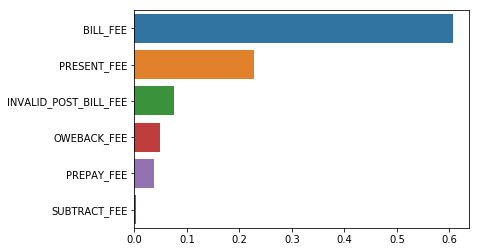

In [83]:
import seaborn as sns
%matplotlib inline
sns.barplot(x=influence, y=X.columns,order=[s[0] for s in sorted_named_scores],orient='h')